## Section 1: Download Malaria dataset

In [1]:
# Do not modify this cell
# Download the Malaria dataset from Google Drive
# Or download it to your local machine if you need: https://drive.google.com/file/d/13iJlt5bJCc3dW1pm4UPns1AgOHyoWQ0a/view?usp=drive_link

import gdown
!gdown 13iJlt5bJCc3dW1pm4UPns1AgOHyoWQ0a
!unzip hw5_data.zip -d hw5_data

Streaming output truncated to the last 5000 lines.
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_192.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_195.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_22.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_24.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_34.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_90.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144855_cell_133.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144855_cell_143.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144855_cell_147.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144855_cell_172.png  
 extracting: hw5_data/data/train/uninfected

In [27]:
# TODO: import your package
import os
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

torch.manual_seed(0)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)   # make sure you are using GPU (CUDA)

Device:  cuda


In [28]:
import zipfile
output_path = 'hw5_data.zip'
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('hw5_data')

In [29]:
dataset_path = 'hw5_data/data'
print(os.listdir(dataset_path))

['test', 'valid', 'train']


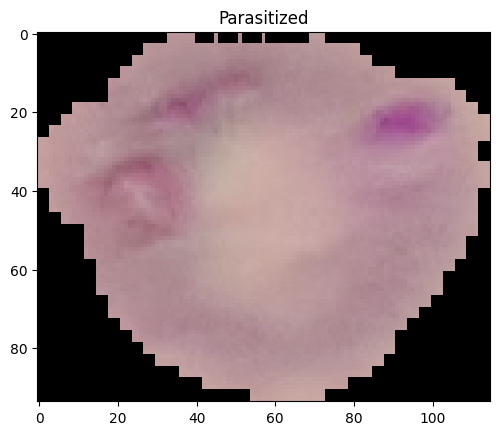

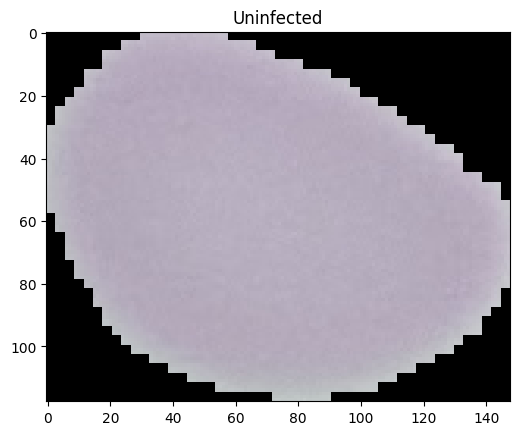

Dimension of the parasitized image: 115 x 94
Dimension of the uninfected image: 148 x 118


In [30]:
# TODO: image visualization
from PIL import Image
import matplotlib.pyplot as plt

# Define paths for parasitized and uninfected images
parasitized_path = os.path.join('hw5_data/data/train', 'parasitized')
uninfected_path = os.path.join('hw5_data/data/train', 'uninfected')

# Get the list of images in each class
parasitized_images = os.listdir(parasitized_path)
uninfected_images = os.listdir(uninfected_path)

# Display one image of a parasitized blood smear
parasitized_image_path = os.path.join(parasitized_path, parasitized_images[0])
parasitized_image = Image.open(parasitized_image_path)
parasitized_image_width, parasitized_image_height = parasitized_image.size

# Display one image of an uninfected blood smear
uninfected_image_path = os.path.join(uninfected_path, uninfected_images[0])
uninfected_image = Image.open(uninfected_image_path)
uninfected_image_width, uninfected_image_height = uninfected_image.size

plt.title('Parasitized')
plt.imshow(parasitized_image)
plt.show()

plt.title('Uninfected')
plt.imshow(uninfected_image)
plt.show()

print(f'Dimension of the parasitized image: {parasitized_image_width} x {parasitized_image_height}')
print(f'Dimension of the uninfected image: {uninfected_image_width} x {uninfected_image_height}')

In [32]:
valid_parasitized_path = os.path.join('hw5_data/data/valid', 'parasitized')
valid_uninfected_path = os.path.join('hw5_data/data/valid', 'uninfected')

valid_parasitized_images = os.listdir(valid_parasitized_path)
valid_uninfected_images = os.listdir(valid_uninfected_path)

v_parasitized_image_path = os.path.join(valid_parasitized_path, valid_parasitized_images[0])
v_parasitized_image = Image.open(v_parasitized_image_path)
v_parasitized_image_width, v_parasitized_image_height = v_parasitized_image.size

v_uninfected_image_path = os.path.join(valid_uninfected_path, valid_uninfected_images[0])
v_uninfected_image = Image.open(v_uninfected_image_path)
v_uninfected_image_width, v_uninfected_image_height = v_uninfected_image.size


print(f'Dimension of the parasitized image: {v_parasitized_image_width} x {v_parasitized_image_height}')
print(f'Dimension of the uninfected image: {v_uninfected_image_width} x {v_uninfected_image_height}')

Dimension of the parasitized image: 208 x 154
Dimension of the uninfected image: 148 x 127


In [33]:
# TODO: store the parameters and hyperparameters in the config dictionary
config = {
    "batch_size": 100,
    "epoch": 10,
    # Add more if you need
}

## Section 2: Prepare your dataset and dataloader

In [35]:
data_dir = "hw5_data/data"  # change it if you need
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")

# TODO: implement your image transformations
# Please refer to: https://pytorch.org/vision/stable/transforms.html
# Most transformations can be done before converting the image into a tensor (using ToTensor())
# Some transforms (e.g. normalization) should be performed after ToTensor()
# Do you need data augmentation on the validation dataset?
# Note: for this dataset, images have different sizes (height and width). Make sure to crop/resize the all the images to the same size.
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(100, 100), antialias=True),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.454, 0.426, 0.529], std=[0.282, 0.269, 0.332])
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(100, 100), antialias=True),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.454, 0.426, 0.529], std=[0.282, 0.269, 0.332])
])

# Create datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(val_dir, transform=valid_transforms)

# TODO: create data loaders using the dataset classes
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,  # TODO: True/False for training? True/False for validation? True/False for testing?
    num_workers = 4,
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = config["batch_size"],
    shuffle = False,
    num_workers = 4,
    pin_memory = True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [36]:
print("Number of classes    : ", len(train_dataset.classes))
print("Shape of image       : ", train_dataset[0][0].shape)
print("Train batches        : ", train_loader.__len__())
print("No. of train images  : ", train_dataset.__len__())
print("No. of valid images  : ", valid_dataset.__len__())

Number of classes    :  2
Shape of image       :  torch.Size([3, 100, 100])
Train batches        :  176
No. of train images  :  17564
No. of valid images  :  4312


In [37]:
# Check if your dataloader is working
# The shape of images should be: (batch_size, number of channels, image height, image width)
# The shape of labels should be: (batch_size)
for _, data in enumerate(train_loader):
    images, labels = data
    print(images.shape, labels.shape)
    break

torch.Size([100, 3, 100, 100]) torch.Size([100])


## Section 3. Create your CNN model

In [38]:
# TODO: set up your model here
# Note that there are 2 classes (parasitized and uninfected) we want to predict
class Model(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # TODO: define your model architecture
        resnet_model = torchvision.models.resnet18(pretrained=True)
        in_features = resnet_model.fc.in_features
        resnet_model.fc = nn.Linear(in_features, num_classes)
        self.model = resnet_model


    def forward(self, x):
        # TODO: define forward pass
        return self.model(x)

model = Model().to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.2MB/s]


In [39]:
# We provide the loss function and optimizer here. Feel free to choose any other loss function and optimizer if you need.
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Section 4. Train your model

In [40]:
# train/validation/test functions for each epoch have been provided and you don't need to modify them.
# Reference: 11785 Introduction to Deep Learning
def train(model, dataloader, optimizer, criterion):
    model.train()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    num_correct = 0.0
    total_loss = 0.0

    # Iterate all the training data and pass them into the model
    for idx, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # zero all the gradients of the variable

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward propagation
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward propagation
        loss.backward()
        # Gradient descent
        optimizer.step()

        # Update no. of correct image predictions and loss so that we can calculate the accuracy and loss for this epoch easily
        num_correct += int((torch.argmax(outputs, dim=1)==labels).sum())
        total_loss += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc = "{:.04f}%".format(num_correct/(config["batch_size"]*(idx+1))*100),
            loss = "{:.04f}".format(float(total_loss/(idx+1))),
        )

        batch_bar.update()

    batch_bar.close()

    # Calculate the total accuracy and loss for this epoch
    acc = num_correct/(config["batch_size"]*len(dataloader))*100
    total_loss = float(total_loss/len(dataloader))

    return acc, total_loss

In [41]:
def validate(model, dataloader, criterion):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Validate')

    num_correct = 0.0
    total_loss = 0.0

    for idx, (images, labels) in enumerate(dataloader):

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        # For validation, we use the inference mode
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, dim=1)==labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc= "{:.04f}%".format(num_correct/(config["batch_size"]*(idx+1))*100),
            loss= "{:.04f}".format(float(total_loss/(idx+1)))
        )

        batch_bar.update()

    batch_bar.close()
    acc = num_correct/(config["batch_size"]*len(dataloader))*100
    total_loss = float(total_loss/len(dataloader))

    return acc, total_loss

In [44]:
# TODO: create lists that track your loss and accuracy during training
all_train_acc = []
all_valid_acc = []
all_train_loss = []
all_valid_loss = []

# Iterate over the number epochs you specified in your config dictionary.
for epoch in range(config["epoch"]):
    # Train your model
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    # print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
    #     epoch + 1,
    #     config["epoch"],
    #     train_acc,
    #     train_loss))

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
    epoch + 1,
    config["epoch"],
    train_acc,
    train_loss,
    optimizer.param_groups[0]['lr']))


    # Validate your model
    val_acc, val_loss = validate(model, valid_loader, criterion)

    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    # TODO: store your loss and accuracy to the lists for this epoch
    all_train_acc.append(train_acc)
    all_train_loss.append(train_loss)
    all_valid_acc.append(val_acc)
    all_valid_loss.append(val_loss)


Epoch 1/10: 
Train Acc 87.9830%	 Train Loss 0.2746	 Learning Rate 0.0010


Val Acc 83.4318%	 Val Loss 0.3274



Epoch 2/10: 
Train Acc 88.1193%	 Train Loss 0.2659	 Learning Rate 0.0010


Val Acc 84.8182%	 Val Loss 0.2968



Epoch 3/10: 
Train Acc 88.5739%	 Train Loss 0.2606	 Learning Rate 0.0010


Val Acc 85.5227%	 Val Loss 0.2868



Epoch 4/10: 
Train Acc 88.6534%	 Train Loss 0.2584	 Learning Rate 0.0010


Val Acc 84.5000%	 Val Loss 0.2985



Epoch 5/10: 
Train Acc 88.8466%	 Train Loss 0.2535	 Learning Rate 0.0010


Val Acc 85.1591%	 Val Loss 0.2919



Epoch 6/10: 
Train Acc 89.0057%	 Train Loss 0.2499	 Learning Rate 0.0010


Val Acc 85.5909%	 Val Loss 0.2840



Epoch 7/10: 
Train Acc 88.8182%	 Train Loss 0.2477	 Learning Rate 0.0010


Val Acc 85.6818%	 Val Loss 0.2874



Epoch 8/10: 
Train Acc 89.3523%	 Train Loss 0.2429	 Learning Rate 0.0010


Val Acc 84.4318%	 Val Loss 0.3176



Epoch 9/10: 
Train Acc 89.1477%	 Train Loss 0.2454	 Learning Rate 0.0010


Val Acc 84.9545%	 Val Loss 0.3147



Epoch 10/10: 
Train Acc 89.5455%	 Train Loss 0.2374	 Learning Rate 0.0010


Val Acc 84.2727%	 Val Loss 0.3054


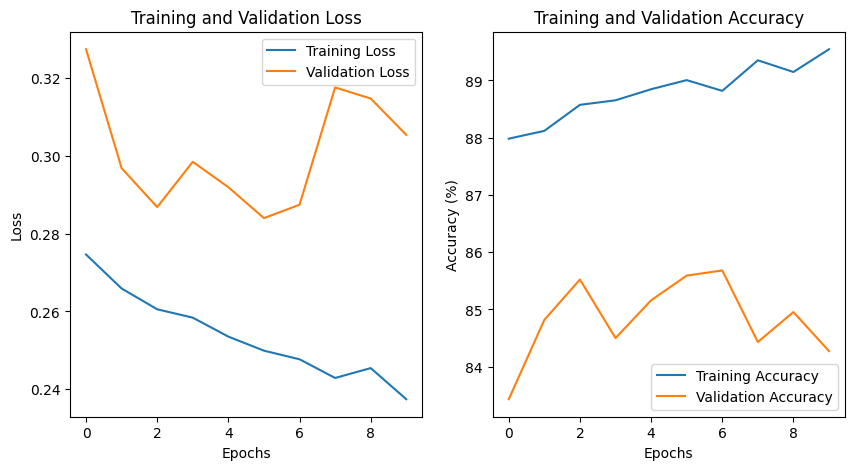

In [45]:
# TODO: plot your loss/accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(all_train_loss, label='Training Loss')
plt.plot(all_valid_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(all_train_acc, label='Training Accuracy')
plt.plot(all_valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


# Section 5. Evaluate your model

In [46]:
# TODO: create the dataset and dataloader for your test data
test_dir = os.path.join(data_dir, "test")

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(100, 100), antialias=True),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.454, 0.426, 0.529], std=[0.282, 0.269, 0.332])
])

test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=test_transforms)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 4,
    pin_memory  = True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [47]:
# No need to modify
def test(model, dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  pred_labels = []
  true_labels = []

  for _, (images, labels) in enumerate(dataloader):
      images = images.to(DEVICE)

      with torch.inference_mode():
          # Predict on the test data
          outputs = model(images)

      outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy().tolist()
      labels = labels.detach().cpu().numpy().tolist()
      pred_labels.extend(outputs)
      true_labels.extend(labels)

      batch_bar.update()

  batch_bar.close()

  return pred_labels, true_labels

In [49]:
import sklearn.metrics
# TODO: make prediction on unseen test data (hint: use the test() function provided above)
pred_labels, true_labels = test(model, test_loader)

# TODO: calculate the accuracy score
accuracy = sklearn.metrics.accuracy_score(true_labels, pred_labels)
print(f"Test Accuracy: {accuracy:.2f}%")

# TODO: calculate the confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(confusion_matrix)


Test Accuracy: 0.89%
Confusion Matrix:
[[3044  527]
 [ 250 3322]]


Normalized Confusion Matrix


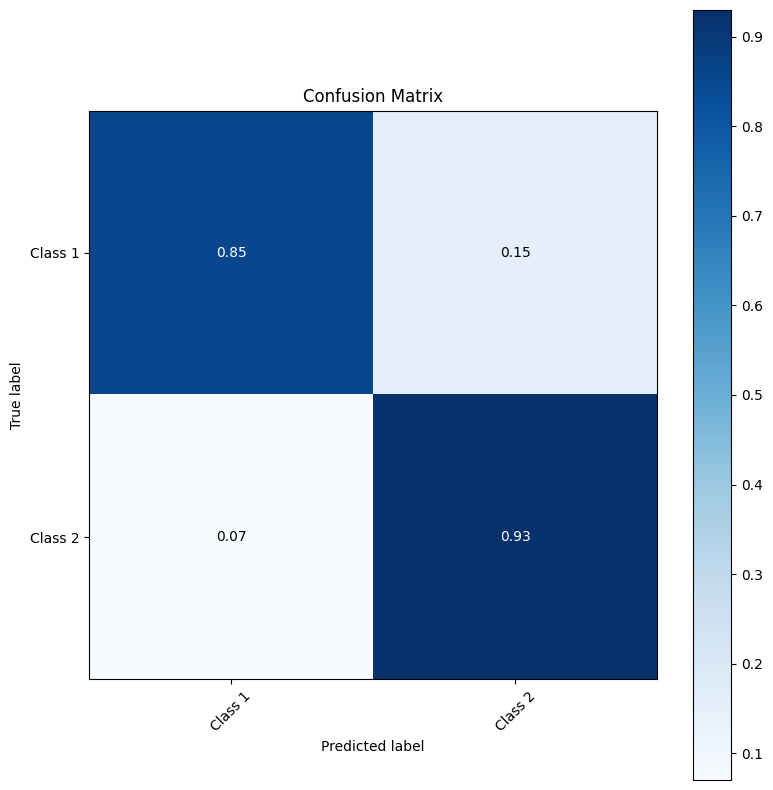

In [51]:
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, classes=['Class 1', 'Class 2'], normalize=True)
plt.show()
